## Linear Regression Models and Regularization

In this notebook, we go over Linear Regression methods (with and without regularization: LinearRegression, Ridge, Lasso, ElasticNet) to predict the __log_votes__ field of our review dataset. 

1. Reading the dataset
2. Exploratory data analysis and missing value imputation
3. Stop word removal and stemming
4. Scaling numerical fields
5. Splitting the training dataset into training and validation
6. Computing Bag of Words features
7. Fitting Linear Regression models and checking the validation performance
    * Find more details on the classical Linear Regression models with and without regularization here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
8. Ideas for improvement

*Note: Could use the processed data from Day 1 to save on redundant work (1-6), and start at 7.*

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __rating:__ Rating of the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)


### 1. Reading the dataset

We will use the __pandas__ library to read our dataset.

In [1]:
import pandas as pd

df = pd.read_csv('../../data/examples/NLP-REVIEW-DATA-REGRESSION.csv')
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

### 2. Exploratory data analysis and missing values imputation

Let's look at the range and distribution of log_votes

In [2]:
df["log_votes"].min()

0.0

In [3]:
df["log_votes"].max()

7.799753318287247

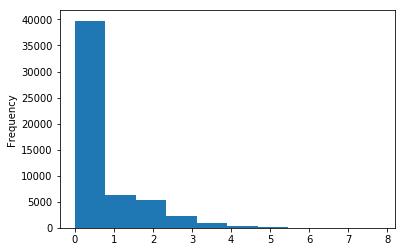

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [5]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


Let's fill-in the missing values for __reviewText__ below. We will just use the placeholder "Missing" here.

In [6]:
df["reviewText"].fillna("Missing", inplace=True)

### 3. Stop word removal and stemming

In [7]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [8]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [9]:
print("Pre-processing the reviewText field")
df["reviewText"] = process_text(df["reviewText"].tolist()) 

Pre-processing the reviewText field


### 4. Scaling numerical fields:

We will apply min-max scaling to our rating field so that they will be between 0-1.

In [10]:
df["rating"] = (df["rating"] - df["rating"].min())/(df["rating"].max()-df["rating"].min())
df["time"] = (df["time"] - df["time"].min())/(df["time"].max()-df["time"].min())

### 5. Splitting the training dataset into training and validation

Sklearn library has a useful function to split datasets. We will use the __train_test_split()__ function. In the example below, we get 90% of the data for training and 10% is left for validation.

In [11]:
from sklearn.model_selection import train_test_split

# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "rating", "time"]],
                                                  df["log_votes"].tolist(),
                                                  test_size=0.10,
                                                  shuffle=True
                                                 )

### 6. Computing Bag of Words Features

We are using binary features here. TF and TF-IDF are other options.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Initialize the binary count vectorizer
tfidf_vectorizer = CountVectorizer(binary=True,
                                   max_features=50 # Limit the vocabulary size
                                  )
# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["reviewText"].tolist())
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["reviewText"].tolist())

Let's print our vocabulary below. The number next to the word is its index in the vocabulary.

In [13]:
print(tfidf_vectorizer.vocabulary_)

{'new': 22, 'find': 10, 'not': 23, 'make': 18, 'work': 47, 'much': 20, 'use': 39, 'would': 48, 'get': 11, 'great': 13, 'tri': 37, 'run': 32, 'instal': 15, 'program': 28, 'need': 21, 'could': 5, 'purchas': 29, 'back': 1, 'price': 25, 'also': 0, 'window': 46, 'version': 42, 'buy': 3, 'softwar': 33, 've': 41, 'still': 34, 'way': 44, 'want': 43, 'well': 45, 'year': 49, 'time': 36, 'good': 12, 'comput': 4, 'support': 35, 'help': 14, 'better': 2, 'upgrad': 38, 'one': 24, 'problem': 26, 'download': 6, 'user': 40, 'like': 16, 'file': 9, 'recommend': 31, 'even': 8, 'mani': 19, 'product': 27, 'look': 17, 'easi': 7, 'realli': 30}


Let's merge our features to train a model.

In [14]:
import numpy as np
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train["rating"].values, 
                                    X_train["time"].values))
X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                  X_val["rating"].values,
                                  X_val["time"].values))

### 7. Fitting Linear Regression models and checking the validation performance

#### 7.1  LinearRegression
Let's first fit __LinearRegression__ from Sklearn library, and check the performance on the validation dataset. Using the __coef___ atribute, we can also print the learned weights of the model.

Find more details on __LinearRegression__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lrRegressor = LinearRegression()
lrRegressor.fit(X_train_features, y_train)
lrRegressor_val_predictions = lrRegressor.predict(X_val_features)
print("LinearRegression on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lrRegressor_val_predictions),r2_score(y_val, lrRegressor_val_predictions)))
print("LinearRegression model weights: \n", lrRegressor.coef_)

LinearRegression on Validation: Mean_squared_error: 0.648069,  R_square_score: 0.325858
LinearRegression model weights: 
 [ 0.09793939  0.03072356  0.03025759  0.06853792 -0.03048919 -0.0095029
  0.01274484  0.00886676  0.055232    0.0263559   0.0583376   0.04486303
  0.01437074  0.01733063  0.04792175  0.04743849  0.03689734  0.15534421
  0.09565253  0.09323987  0.040978    0.02797287  0.08146887  0.03520674
  0.06615644  0.0451486  -0.03235873  0.03678624  0.08368014  0.08777283
  0.0442719   0.03564256  0.0381178   0.07672628  0.02092084  0.09199393
  0.01830677  0.04117502  0.07961086 -0.00216006  0.07643235  0.10232756
  0.07097625  0.10329567  0.09035594  0.03084035  0.04299266 -0.0021919
 -0.0028968  -0.01121526 -0.36334067 -1.73159335]


#### 7.2  Ridge (Linear Regression with L2 regularization)
Let's now fit __Ridge__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __Ridge__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

To improve the performance of a LinearRegression model, __Ridge__ is tuning model complexity by adding a $L_2$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  {alpha}∗||\textbf{w}||_2^2$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_2^2 = \sum \textbf{w}_i^2$.

The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of $alpha$, weaker regularization; larger value of $alpha$, stronger regularization. 


In [16]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

ridgeRegressor = Ridge(alpha = 100)
ridgeRegressor.fit(X_train_features, y_train)
ridgeRegressor_val_predictions = ridgeRegressor.predict(X_val_features)
print("Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, ridgeRegressor_val_predictions),r2_score(y_val, ridgeRegressor_val_predictions)))

print("Ridge model weights: \n", ridgeRegressor.coef_)

Ridge on Validation: Mean_squared_error: 0.648224,  R_square_score: 0.325696
Ridge model weights: 
 [ 9.90423172e-02  3.09038542e-02  3.25733120e-02  7.01114795e-02
 -2.80843919e-02 -7.87783542e-03  8.33568182e-03  9.62130664e-03
  5.81305666e-02  2.62106102e-02  5.88529705e-02  4.70902255e-02
  1.47878081e-02  1.73958868e-02  4.89547209e-02  4.85966204e-02
  3.86726015e-02  1.53638561e-01  9.66630586e-02  9.25984331e-02
  4.22587608e-02  2.76965546e-02  8.25048587e-02  3.83728581e-02
  6.87382595e-02  4.32234603e-02 -2.75765284e-02  4.04380799e-02
  8.74142521e-02  8.68740753e-02  4.59853450e-02  3.73160002e-02
  4.02878116e-02  7.99014767e-02  2.16254532e-02  9.26246962e-02
  1.99557153e-02  4.18727862e-02  7.97201636e-02 -7.51192403e-05
  7.72192149e-02  1.00912243e-01  7.20122660e-02  1.02348429e-01
  9.00071548e-02  3.21004127e-02  4.12699765e-02 -2.36702282e-03
 -5.92735245e-04 -1.22188844e-02 -3.58546122e-01 -1.62828263e+00]


#### 7.3 LASSO (Linear Regression with L1 regularization)
Let's also fit __Lasso__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __Lasso__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

__Lasso__ is tuning model complexity by adding a $L_1$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  alpha∗||\textbf{w}||_1$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_1 = \sum |\textbf{w}_i|$. 

Again, the strength of the regularization is controlled by the regularizer parameter, $alpha$. Due to the geometry of $L_1$ norm, with __Lasso__, some of the weights will shrink all the way to 0, leading to sparsity - some of the features are not contributing to the model afterall!

In [17]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

lassoRegressor = Lasso(alpha = 0.001)
lassoRegressor.fit(X_train_features, y_train)
lassoRegressor_val_predictions = lassoRegressor.predict(X_val_features)
print("Lasso on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lassoRegressor_val_predictions),r2_score(y_val, lassoRegressor_val_predictions)))

print("Lasso model weights: \n", lassoRegressor.coef_)

Lasso on Validation: Mean_squared_error: 0.647624,  R_square_score: 0.326321
Lasso model weights: 
 [ 0.09688201  0.02449483  0.0244337   0.06308828 -0.01598072 -0.
  0.00565951  0.00212218  0.05397095  0.0198812   0.05279747  0.04639567
  0.01074171  0.01143645  0.04224879  0.0431729   0.03796074  0.15196206
  0.09536239  0.08700969  0.03802485  0.0270612   0.07915763  0.03824943
  0.06679943  0.03595044 -0.01400202  0.0368887   0.08328988  0.08123058
  0.03981443  0.0262013   0.03124798  0.07760076  0.01523769  0.08596605
  0.01899642  0.03965802  0.07253332  0.          0.07236303  0.09493329
  0.07226925  0.10182552  0.08682682  0.02647802  0.03865926  0.
  0.         -0.         -0.35586278 -1.71529134]


#### 7.4 ElasticNet (Linear Regression with L2 and L1 regularization)
Let's finally try __ElasticNet__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __ElasticNet__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

__ElasticNet__ is tuning model complexity by adding both $L_2$ and $L_1$ penalty scores for complexity to the model's cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  0.5*alpha∗(1-\textit{l1}_{ratio})||\textbf{w}||_2^2 + alpha∗\textit{l1}_{ratio}∗||\textbf{w}||_1$$

and using two parameters, $alpha$ and $\textit{l1}_{ratio}$, to control the strength of the regularization.

In [18]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

enRegressor = ElasticNet(alpha = 0.001, l1_ratio = 0.1)
enRegressor.fit(X_train_features, y_train)
enRegressor_val_predictions = enRegressor.predict(X_val_features)
print("ElasticNet on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, enRegressor_val_predictions),r2_score(y_val, enRegressor_val_predictions)))

print("ElasticNet model weights: \n", enRegressor.coef_)

ElasticNet on Validation: Mean_squared_error: 0.647996,  R_square_score: 0.325934
ElasticNet model weights: 
 [ 9.82800843e-02  3.00756297e-02  3.06787346e-02  6.86916195e-02
 -2.80560052e-02 -6.91965697e-03  9.93364846e-03  8.34807430e-03
  5.63393700e-02  2.55362860e-02  5.79061627e-02  4.59107511e-02
  1.42000625e-02  1.66973516e-02  4.77680811e-02  4.75346558e-02
  3.77139501e-02  1.54220981e-01  9.60265463e-02  9.22823863e-02
  4.11874305e-02  2.76493129e-02  8.16679449e-02  3.67273383e-02
  6.73286331e-02  4.33858903e-02 -2.84929709e-02  3.83969813e-02
  8.52246961e-02  8.66403353e-02  4.45713698e-02  3.51444782e-02
  3.84760487e-02  7.81591824e-02  2.05712327e-02  9.16318101e-02
  1.90130728e-02  4.11652924e-02  7.89295321e-02 -1.44406580e-04
  7.63939950e-02  1.00865881e-01  7.14494394e-02  1.02626115e-01
  8.97985685e-02  3.07464577e-02  4.16003134e-02 -1.27222697e-03
 -1.51858848e-04 -1.06788548e-02 -3.60342382e-01 -1.68225517e+00]


#### 7.5 Weights shrinkage and sparsity

Let's compare weights ranges for all these regression models:

In [19]:
print('LinearRegression weights range: \n', np.abs(lrRegressor.coef_).min(), np.abs(lrRegressor.coef_).max())
print('Ridge weights range: \n', np.abs(ridgeRegressor.coef_).min(), np.abs(ridgeRegressor.coef_).max())
print('Lasso weights range: \n', np.abs(lassoRegressor.coef_).min(), np.abs(lassoRegressor.coef_).max())
print('ElasticNet weights range: \n', np.abs(enRegressor.coef_).min(), np.abs(enRegressor.coef_).max())

LinearRegression weights range: 
 0.002160056305899667 1.7315933466728093
Ridge weights range: 
 7.511924032907017e-05 1.6282826281170233
Lasso weights range: 
 0.0 1.7152913386341215
ElasticNet weights range: 
 0.00014440658019424025 1.6822551664314198


The weights of all regularized models are lowered compared to __LinearRegression__, with some of the weights of __Lasso__ and __ElasticNet__ shrinked all the way to 0. Using sparsity, the __Lasso__ regularization reduces the number of features, performing feature selection.

#### 8. Ideas for improvement

One way to improve the performance of a linear regression model is to try different strenghts of regularization, here controlled by the parameters $alpha$ and $\textit{l1}_{ratio}$.